In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns

%matplotlib inline



from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve 
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter, OrderedDict 
from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.feature_selection import f_classif, f_regression, SelectKBest
import time   

import warnings
# Suppress annoying harmless error.
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Read in previously cleaned data
df_all=pd.read_pickle('clean_data.pkl')

In [3]:
df_all=df_all[df_all['Gender']!=3]
df_all = df_all[df_all['Age']<30]

In [4]:
# One hot encode categorical data
cat_features = ['Dewormed', 'Sterilized', 'Breed1', 'Type', 'Breed2', 'State', 'Gender', 'Color1', 
                'Color2', 'Color3']

for feature in cat_features:
    encoder = LabelEncoder()
    encoder.fit(df_all[feature].append(df_all[feature]))
    df_all[feature + '_label'] = encoder.transform(df_all[feature])

In [5]:
# Standardize numerical features
num_features = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt','MaturitySize', 'FurLength', 'Health']

for feature in num_features:
    scaler = StandardScaler()
    scaler.fit(df_all[feature].append(df_all[feature]).astype(np.float64).values[:, np.newaxis])    
    df_all[feature + '_scaled'] = scaler.transform(df_all[feature].astype(np.float64).values[:, np.newaxis])

In [6]:
# Combine numerical and categorical features into X

num_features = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt','MaturitySize', 'FurLength', 'Health']
cat_features = ['Dewormed', 'Sterilized', 'Breed1', 'Type','Breed2', 'State', 'Gender', 'Color1', 
                'Color2', 'Color3']

features = cat_features+num_features

X=pd.concat([df_all[[x + '_label' for x in cat_features]],df_all[[x + '_scaled' for x in num_features]]],axis=1)

In [7]:
# Check for any missing values in the dataset
X.isnull().values.any()

False

In [8]:
# Define outcome variable as the Adoption Speed
y = df_all['AdoptionSpeed']

In [9]:
X.head()

,Dewormed_label,Sterilized_label,Breed1_label,Type_label,Breed2_label,State_label,Gender_label,Color1_label,Color2_label,Color3_label,Age_scaled,Quantity_scaled,Fee_scaled,VideoAmt_scaled,PhotoAmt_scaled,MaturitySize_scaled,FurLength_scaled,Health_scaled
0,1,1,149,1,0,2,0,0,6,0,-0.456474,-0.234556,1.064228,-0.17109,-0.835645,-1.665190,-0.761013,-0.173122
1,2,2,119,1,0,12,0,0,1,0,-0.776190,-0.234556,-0.277255,-0.17109,-0.534192,0.249703,0.952806,-0.173122
2,0,1,156,0,0,2,0,1,6,0,-0.776190,-0.234556,-0.277255,-0.17109,0.973069,0.249703,0.952806,-0.173122
3,0,1,156,0,0,12,1,0,1,0,-0.296616,-0.234556,1.734969,-0.17109,1.274522,0.249703,-0.761013,-0.173122
4,1,1,156,0,0,2,0,0,0,0,-0.776190,-0.234556,-0.277255,-0.17109,-0.232740,0.249703,-0.761013,-0.173122


In [10]:
X.shape

(11411, 18)

In [11]:
# Create training and testing sets. Use 25% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

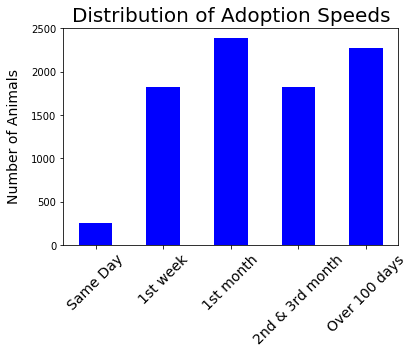

In [12]:
labels = ['Same Day', '1st week', '1st month', '2nd & 3rd month', 'Over 100 days']
index = np.arange(len(labels))
plt.hist(y_train,bins = np.arange(6)-.5, rwidth=.5, color='b')
plt.xticks(index, labels,fontsize=14,rotation = 45)
plt.title('Distribution of Adoption Speeds',fontsize=20)
plt.ylabel('Number of Animals',fontsize=14, labelpad=10)
plt.show()

In [13]:
# Due to the class imbalance in the animal adoption rate outcome, SMOTE will be used to oversample the training set.
sm = SMOTENC(categorical_features=[0,1,2,3,4], random_state=0)
X_train, y_train = sm.fit_sample(X_train, y_train) 
X_train = pd.DataFrame(data=X_train, columns=X_test.columns)

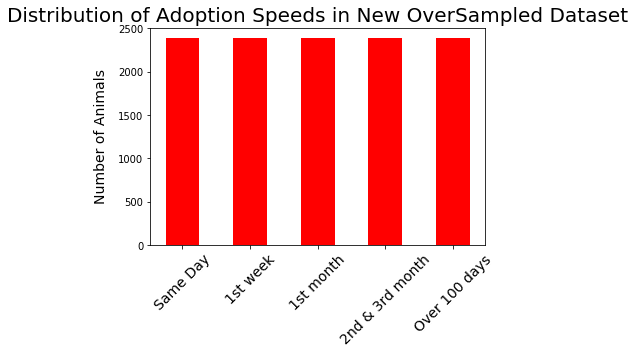

In [14]:
labels = ['Same Day', '1st week', '1st month', '2nd & 3rd month', 'Over 100 days']
index = np.arange(len(labels))
plt.hist(y_train,bins = np.arange(6)-.5, rwidth=.5, color='r')
plt.xticks(index, labels,fontsize=14,rotation = 45)
plt.title('Distribution of Adoption Speeds in New OverSampled Dataset',fontsize=20)
plt.ylabel('Number of Animals',fontsize=14, labelpad=10)
plt.show()

In [15]:
# Define a function to evaluate each model
def model_eval(model, X_train, y_train, X_test, y_test, pred, model_type='Multiclass'):
    if model_type == 'Binary':
        labels = ['Less than 100 days', 'Over 100 days']
    else:   
        labels = ['Same Day', '1st week', '1st month', '2nd & 3rd month', 'Over 100 days']
        
    print('Training set accuracy:\t\t', round(model.score(X_train, y_train),2))
    print('Test set accuracy:\t\t\t', round(model.score(X_test, y_test),2))
    
    conf_mat = confusion_matrix(y_test, pred)
    
    cv = cross_val_score(model, X_train, y_train, cv=10) 
    print('\nCross validation results: {:.3}+/-{:.3}  \n \n '.format(cv.mean(), 2*cv.std()))
    
    plt.figure(figsize = (12,8)) 
    sns.heatmap(conf_mat,annot=True,annot_kws={"size": 15}, fmt='d',cmap='GnBu',cbar =False,xticklabels=labels,yticklabels=labels)
    plt.xlabel('Target', fontsize=20)     
    plt.ylabel('Predicted', fontsize=20) 
    
    model_name = str(model)
    ind=model_name.index('(')
    plt.title(model_name[0:ind], fontsize=24,y=1.025)
    plt.show()
    
    
    return cv
    

Training set accuracy:		 0.62
Test set accuracy:			 0.28

Cross validation results: 0.453+/-0.0924  
 
 


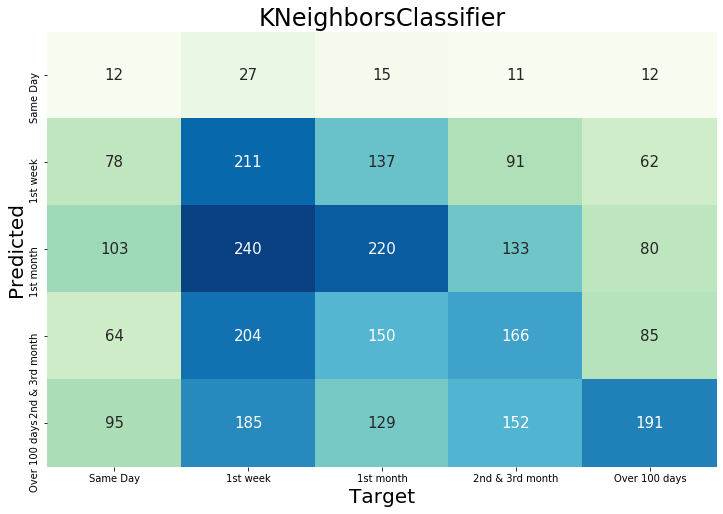

Training set accuracy:		 0.97
Test set accuracy:			 0.35

Cross validation results: 0.491+/-0.116  
 
 


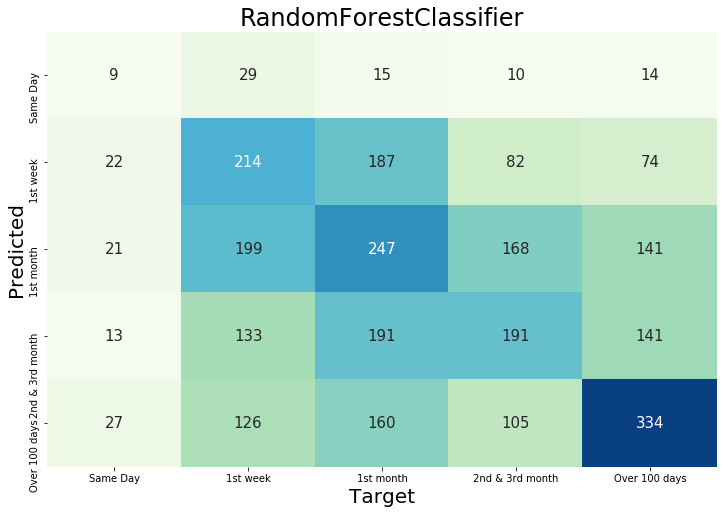

Training set accuracy:		 0.64
Test set accuracy:			 0.31

Cross validation results: 0.45+/-0.0765  
 
 


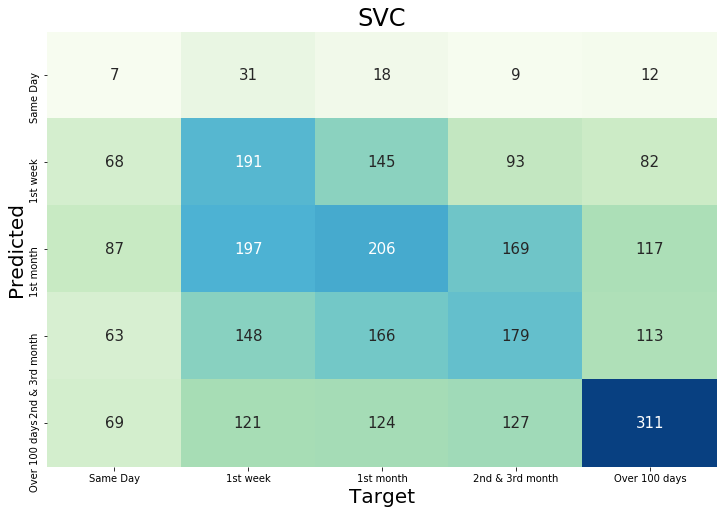

Training set accuracy:		 0.56
Test set accuracy:			 0.4

Cross validation results: 0.481+/-0.107  
 
 


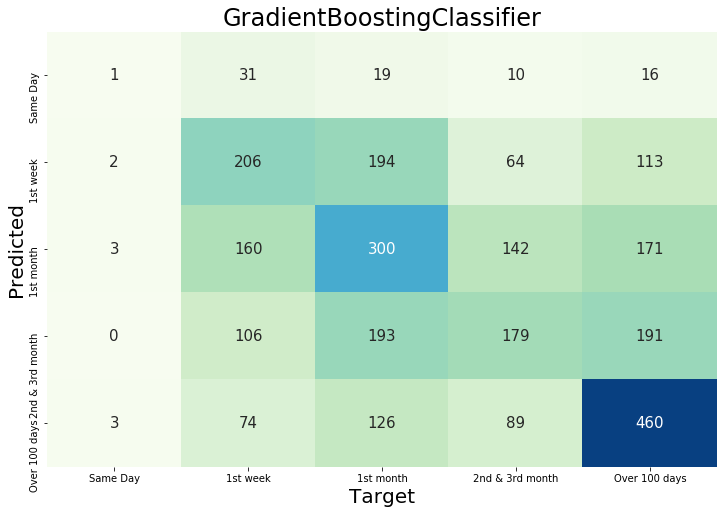

Training set accuracy:		 0.52
Test set accuracy:			 0.4

Cross validation results: 0.465+/-0.108  
 
 


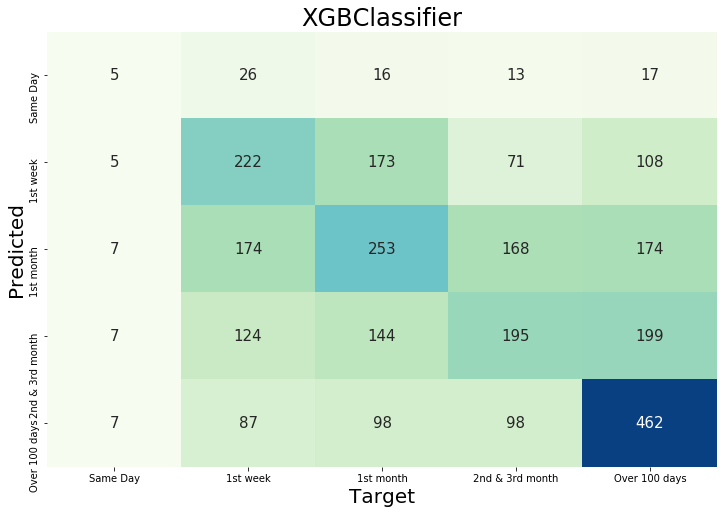

In [16]:
start = time.time() 
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train) 
pred_knn = knn.predict(X_test) 
knn_cv_scores = model_eval(knn,X_train, y_train, X_test, y_test, knn.predict(X_test))
knn_time = (time.time()-start)/60  

start = time.time() 
rfc = RandomForestClassifier() 
rfc.fit(X_train, y_train) 
pred_rfc =rfc.predict(X_test) 
rfc_cv_scores = model_eval(rfc,X_train, y_train, X_test, y_test, rfc.predict(X_test))
rfc_time = (time.time()-start)/60  

start = time.time() 
svc=SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
svc_cv_scores = model_eval(svc,X_train, y_train, X_test, y_test, svc.predict(X_test))
svc_time = (time.time()-start)/60  

# Gradient Boost
start = time.time() 
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, y_train)
gbc.predict(X_test)
gbc_cv_scores=model_eval(gbc, X_train, y_train, X_test, y_test, gbc.predict(X_test))
gbc_time = (time.time()-start)/60  

start = time.time() 
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
pred_xgb = xgb.predict(X_test)
xgb_cv_scores=model_eval(xgb,X_train, y_train, X_test, y_test, xgb.predict(X_test))
xgb_time = (time.time()-start)/60  

In [17]:
times = [ knn_time, rfc_time, svc_time, gbc_time, xgb_time]

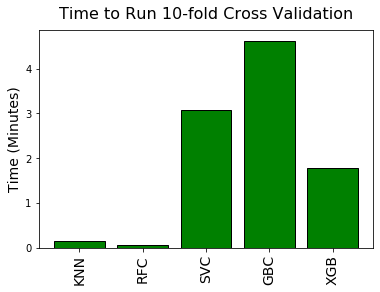

In [18]:
mod_labels = ['KNN', 'RFC', 'SVC', 'GBC', 'XGB']
model_index = np.arange(len(mod_labels))
plt.bar(range(5),times,color='g', edgecolor='k')
plt.xticks(model_index, mod_labels,fontsize=14, rotation=90)
plt.title('Time to Run 10-fold Cross Validation', fontsize=16, y=1.025)
plt.ylabel('Time (Minutes)', fontsize=14)
plt.show()

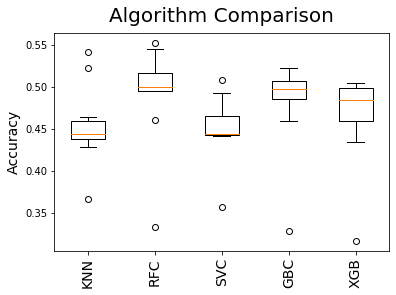

In [21]:
run1 = [knn, rfc,  svc, gbc, xgb]
scores_run1=[knn_cv_scores, rfc_cv_scores, svc_cv_scores, gbc_cv_scores, xgb_cv_scores]

plt.boxplot(scores_run1)
plt.xticks(model_index+1, mod_labels,fontsize=14, rotation=90)
plt.title('Algorithm Comparison', fontsize=20, y=1.025)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [22]:
rfc_accuracy = []
for k in range(1,len(X_train.columns)):
    selector = SelectKBest(f_classif, k=k)
    selector.fit_transform(X_train, y_train)
    names = X_train.columns.values[selector.get_support()]
    scores = selector.scores_[selector.get_support()]
    names_scores = list(zip(names, scores))
    df_features = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
    best_Kfeatures = list(df_features.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])['Feat_names']) 
    rfc.fit(X_train[best_Kfeatures],y_train)
    rfc_accuracy.append(rfc.score(X_test[best_Kfeatures],y_test))

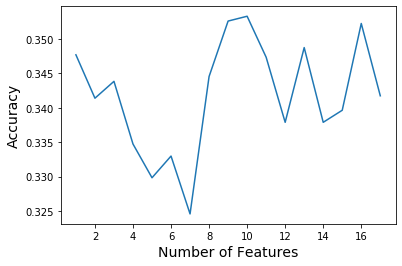

In [23]:
plt.plot(range(1,len(rfc_accuracy)+1),rfc_accuracy)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Number of Features', fontsize=14)
plt.show()

In [24]:
df_all['binary']= np.where(df_all.AdoptionSpeed<4, 0, 1)
y = df_all['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


Training set accuracy:		 0.74
Test set accuracy:			 0.75

Cross validation results: 0.74+/-0.0168  
 
 


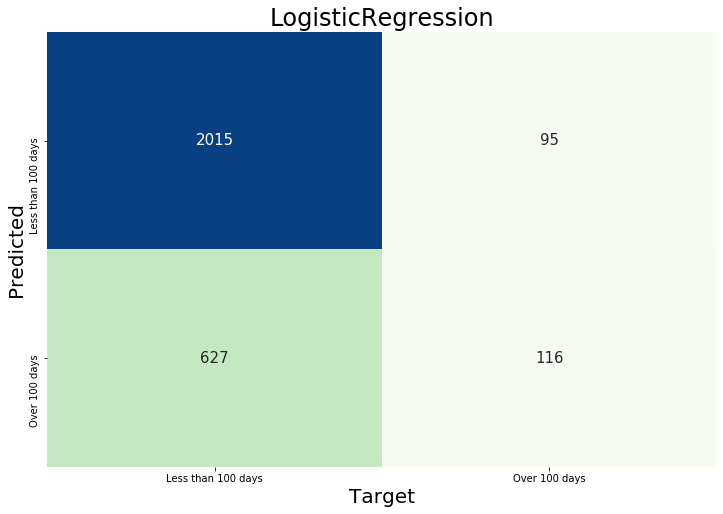

In [25]:
lasso = linear_model.LogisticRegression(penalty='l1')
lasso.fit(X_train,y_train)
pred_lasso = lasso.predict(X_test)
#lasso_cv_scores = cross_val_score(lasso, X_train, y_train, cv=10) 
lasso_cv_scores =model_eval(lasso,X_train, y_train, X_test, y_test, lasso.predict(X_test),model_type='Binary')

Training set accuracy:		 0.97
Test set accuracy:			 0.76

Cross validation results: 0.745+/-0.0205  
 
 


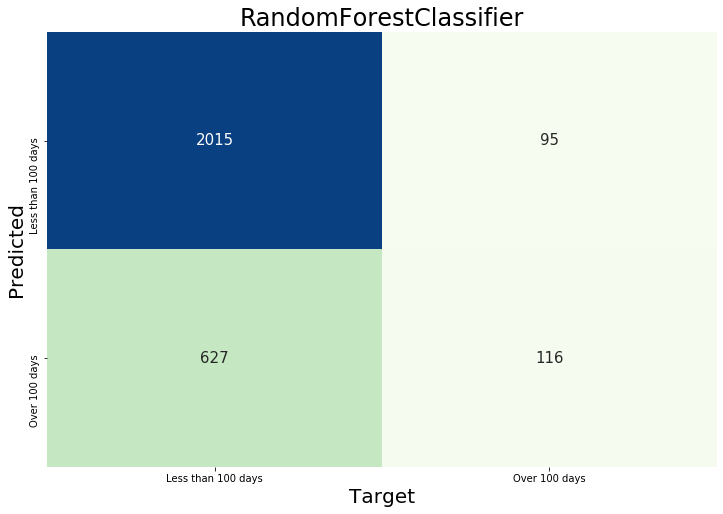

In [26]:
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
rfc_cv_scores =model_eval(rfc,X_train, y_train, X_test, y_test, lasso.predict(X_test),model_type='Binary')

### Hyperparameter Tuning

#### Random Forest

In [27]:
'''param_grid = {'max_depth': [20, 50, 100],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [10, 100],
              'criterion': ['gini', 'entropy']}
grid_rfc = RandomizedSearchCV(rfc, param_grid, return_train_score=False, n_jobs=-1, cv=5, scoring='accuracy')
grid_rfc.fit(X_train, y_train)'''

rfc = RandomForestClassifier(criterion='entropy')
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7528916929547844

In [28]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7592008412197687

In [29]:
rfc = RandomForestClassifier(min_samples_split=3)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7577988082719944

In [30]:
rfc = RandomForestClassifier(min_samples_leaf=3)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7634069400630915

In [31]:
rfc = RandomForestClassifier(max_depth=50)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7511391517700666

In [32]:
rfc = RandomForestClassifier(n_estimators=100,min_samples_leaf=3)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7742726954083421

#### Logistic Regression 

In [33]:
regr=linear_model.LogisticRegression(penalty='l1')
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7469330529267437

In [34]:
regr=linear_model.LogisticRegression(penalty='l1',C=0.1)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7451805117420259

In [35]:
regr=linear_model.LogisticRegression(penalty='l1',C=.01)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7413249211356467

In [36]:
regr=linear_model.LogisticRegression(penalty='l1',C=.001)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7395723799509288

In [37]:
regr=linear_model.LogisticRegression()
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7479845776375745

In [38]:
regr=linear_model.LogisticRegression(C=.1)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.745881528215913

In [39]:
regr=linear_model.LogisticRegression(C=10)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7472835611636873

In [40]:
regr=linear_model.LogisticRegression(C=.01)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7395723799509288

#### L2 penalty with C=0.1 appears to give the best result for logistic regression

### Feature Importance

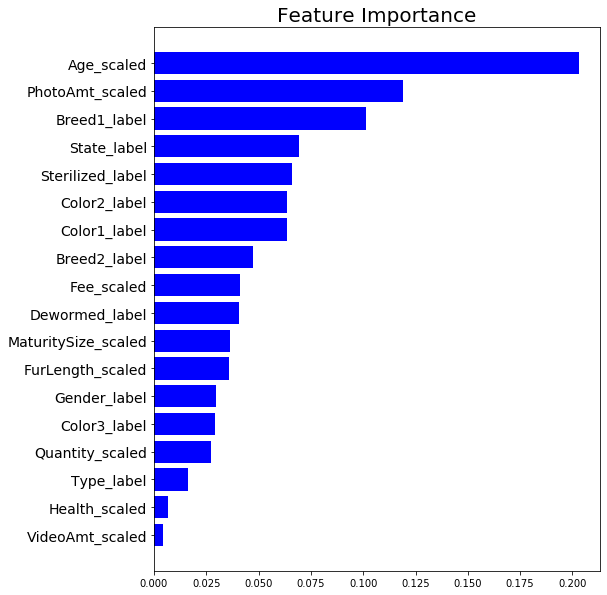

In [41]:
features = X.columns
temp = rfc.feature_importances_
df_imp = pd.DataFrame(temp)
df_imp.columns=["importance"] 
df_imp["labels"] = features
df_imp.sort_values("importance",inplace=True)

index2 = np.arange(len(df_imp))
fig = plt.figure(figsize=(8, 10)) 
plt.subplot('111') 
rects = plt.barh(index2, df_imp["importance"], color= 'b') 
plt.title('Feature Importance', fontsize=20)
plt.yticks(index2, df_imp["labels"], fontsize=14) 
 
plt.show() 

### Run model for dogs only

In [42]:
df_dog=df_all[df_all.Type==1]
X=pd.concat([df_dog[[x + '_label' for x in cat_features]],df_dog[[x + '_scaled' for x in num_features]]],axis=1)
y = df_dog['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [43]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7678803641092328

In [44]:
regr=linear_model.LogisticRegression(C=.1)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7301690507152145

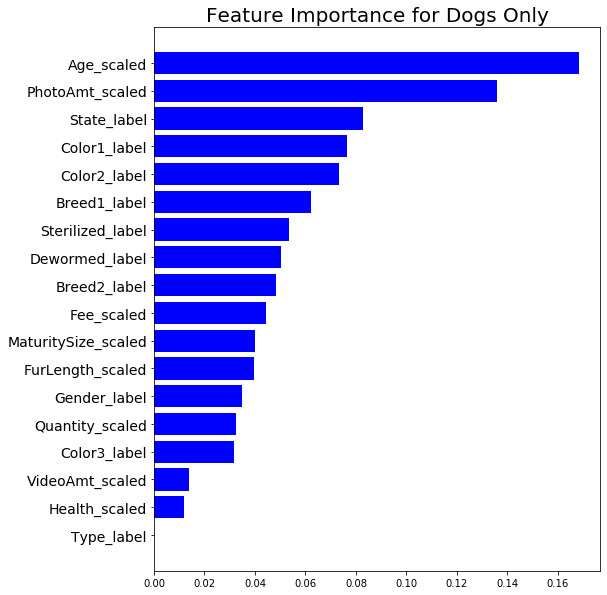

In [45]:
features = X.columns
temp = rfc.feature_importances_
df_imp = pd.DataFrame(temp)
df_imp.columns=["importance"] 
df_imp["labels"] = features
df_imp.sort_values("importance",inplace=True)

index2 = np.arange(len(df_imp))
fig = plt.figure(figsize=(8, 10)) 
plt.subplot('111') 
rects = plt.barh(index2, df_imp["importance"], color= 'b') 
plt.title('Feature Importance for Dogs Only', fontsize=20)
plt.yticks(index2, df_imp["labels"], fontsize=14) 
 
plt.show() 

In [46]:
df_cat=df_all[df_all.Type==1]
X=pd.concat([df_cat[[x + '_label' for x in cat_features]],df_cat[[x + '_scaled' for x in num_features]]],axis=1)
y = df_cat['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [47]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7548764629388817

In [48]:
regr=linear_model.LogisticRegression(C=.1)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)

0.7256176853055917

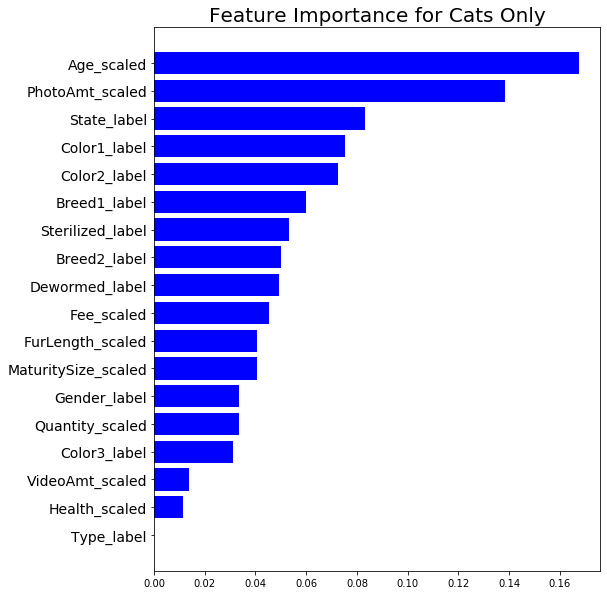

In [49]:
features = X.columns
temp = rfc.feature_importances_
df_imp = pd.DataFrame(temp)
df_imp.columns=["importance"] 
df_imp["labels"] = features
df_imp.sort_values("importance",inplace=True)

index2 = np.arange(len(df_imp))
fig = plt.figure(figsize=(8, 10)) 
plt.subplot('111') 
rects = plt.barh(index2, df_imp["importance"], color= 'b') 
plt.title('Feature Importance for Cats Only', fontsize=20)
plt.yticks(index2, df_imp["labels"], fontsize=14) 
 
plt.show() 

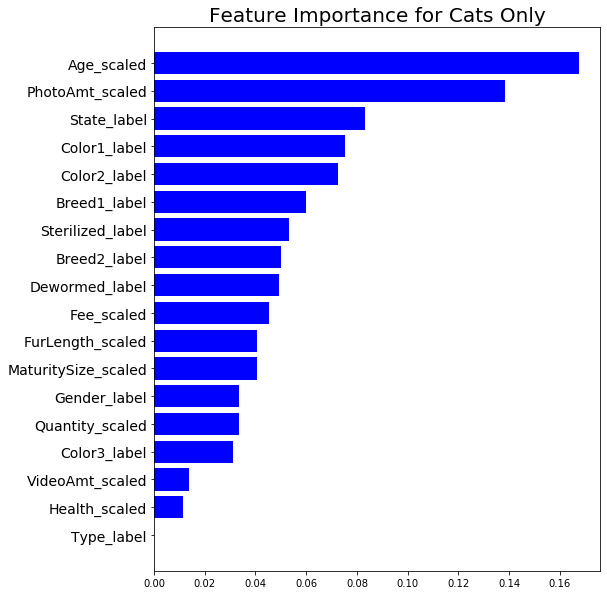

In [50]:
features = X.columns
temp = rfc.feature_importances_
df_imp = pd.DataFrame(temp)
df_imp.columns=["importance"] 
df_imp["labels"] = features
df_imp.sort_values("importance",inplace=True)

index2 = np.arange(len(df_imp))
fig = plt.figure(figsize=(8, 10)) 
plt.subplot('111') 
rects = plt.barh(index2, df_imp["importance"], color= 'b') 
plt.title('Feature Importance for Cats Only', fontsize=20)
plt.yticks(index2, df_imp["labels"], fontsize=14) 
 
plt.show() 

#### Try PCA

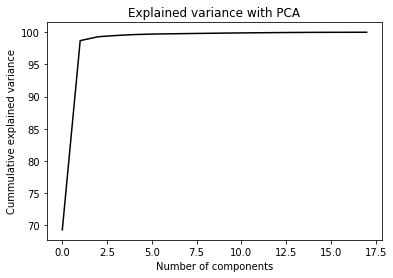

In [51]:
X=X=pd.concat([df_all[[x + '_label' for x in cat_features]],df_all[[x + '_scaled' for x in num_features]]], axis=1)
y=df_all['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_sample(X_train, y_train) 
X_train = pd.DataFrame(data=X_train, columns=X_test.columns)

pca = PCA(n_components=18)
X_PCA = pca.fit_transform(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100., color='k')
plt.xlabel('Number of components')
plt.ylabel('Cummulative explained variance')
plt.title('Explained variance with PCA')
plt.show()

In [52]:
n_components = 3
np.sum(pca.explained_variance_ratio_[:n_components])

0.9929660374329247

Training set accuracy:		 0.98
Test set accuracy:			 0.74

Cross validation results: 0.826+/-0.272  
 
 


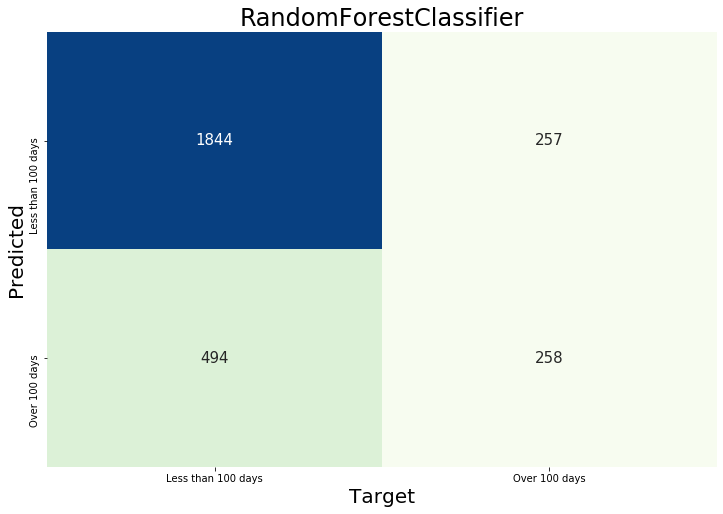

In [53]:
'''X_train = X_PCA[:,:n_components]
X_test_PCA = pca.transform(X_test)
X_test = X_test_PCA[:,:n_components]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)'''

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)
rfc_score = model_eval(rfc,X_train, y_train, X_test, y_test, rfc.predict(X_test),'Binary')

Training set accuracy:		 0.66
Test set accuracy:			 0.65

Cross validation results: 0.653+/-0.0373  
 
 


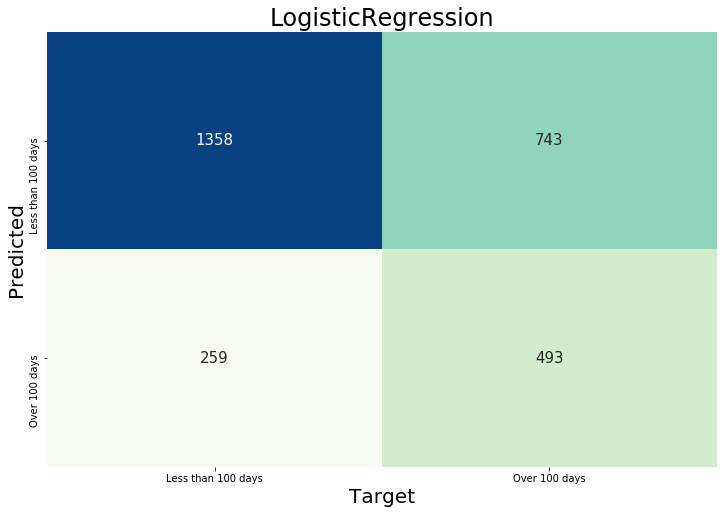

In [54]:
regr=linear_model.LogisticRegression()
regr.fit(X_train,y_train)
regr_score = model_eval(regr,X_train, y_train, X_test, y_test, regr.predict(X_test),'Binary')

### Conclusion
Overall the random forest classification performed the best. 